In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import matplotlib.patches as mpatches


Target coefficient diagnostics:
PDF integral: 0.999845
φ_k[0] (DC): 1.000000
Sum of |φ_k|: 6.907159
Non-zero φ_k: 25
Max |φ_k|: 1.000000

Starting Riccati iLQR iterations...

Initial coefficient validation:
Target coefficients (φ_k):
  k=[0 0]: φ_k=1.000000
  k=[0 1]: φ_k=0.265643
  k=[0 2]: φ_k=-0.673231
  k=[0 3]: φ_k=-0.226551
  k=[0 4]: φ_k=-0.228444
  k=[1 0]: φ_k=0.081164
  k=[1 1]: φ_k=0.075124
  k=[1 2]: φ_k=-0.175790
  k=[1 3]: φ_k=-0.265354
  k=[1 4]: φ_k=0.108310

Current coefficients (c_k):
  k=[0 0]: c_k=1.000000
  k=[0 1]: c_k=0.831254
  k=[0 2]: c_k=-0.437016
  k=[0 3]: c_k=-1.344997
  k=[0 4]: c_k=-1.144123
  k=[1 0]: c_k=0.831254
  k=[1 1]: c_k=0.690983
  k=[1 2]: c_k=-0.363271
  k=[1 3]: c_k=-1.118034
  k=[1 4]: c_k=-0.951057

Weighted ergodic mismatch: 0.688158
Raw mismatch: 18.813697

Iter: 00, Cost: 68.833791, Mu: 1.00e-04
  Line search failed.
Iter: 01, Cost: 68.833791, Mu: 2.00e-04
  Line search failed.
Iter: 02, Cost: 68.833791, Mu: 4.00e-04
  Line search failed

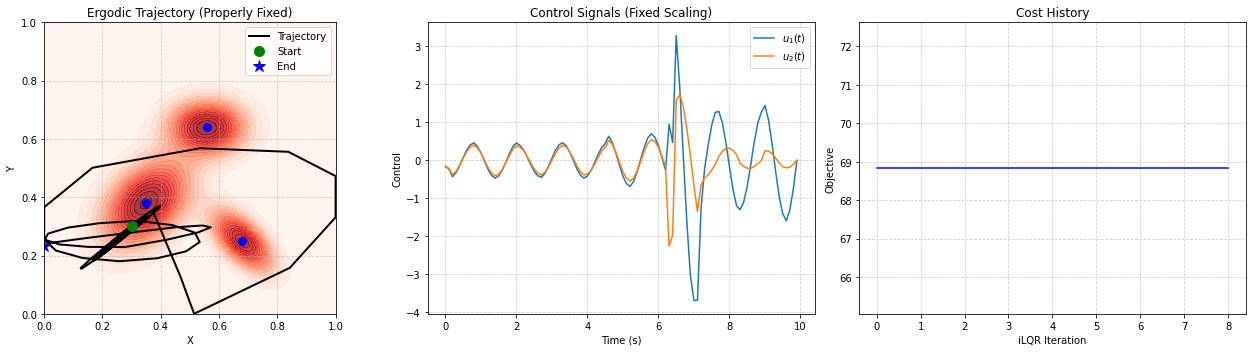


Final control statistics:
u1 range: [-3.691, 3.285]
u2 range: [-2.260, 1.733]
Max |u|: 3.691


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# --- 1. GMM Parameters and Function ---
w = [0.5, 0.2, 0.3]
mu = [np.array([0.35, 0.38]), np.array([0.68, 0.25]), np.array([0.56, 0.64])]
Sigma = [
    np.array([[0.01, 0.004], [0.004, 0.01]]),
    np.array([[0.005, -0.003], [-0.003, 0.005]]),
    np.array([[0.008, 0.0], [0.0, 0.004]])
]
gaussians = [multivariate_normal(mean=m, cov=s) for m, s in zip(mu, Sigma)]

def gmm_pdf(x):
    pdf_val = 0
    for weight, gauss in zip(w, gaussians):
        pdf_val += weight * gauss.pdf(x)
    return pdf_val

# --- 2. Fourier Basis and Target Coefficients (PROPERLY FIXED) ---
L = 1.0
N_basis = 5  # Reduced from 7 to avoid curse of dimensionality

def get_k_vectors(N_basis, dim=2):
    k_vectors = []
    for i in range(N_basis):
        for j in range(N_basis):
            k_vectors.append(np.array([i, j]))
    return np.array(k_vectors)

k_vectors = get_k_vectors(N_basis)
num_k = len(k_vectors)

def F_k(x, k_vec):
    """Normalized cosine basis functions"""
    if k_vec[0] == 0 and k_vec[1] == 0:
        return 1.0  # DC component
    elif k_vec[0] == 0 or k_vec[1] == 0:
        return np.sqrt(2) * np.prod(np.cos(np.pi * k_vec * x / L))
    else:
        return 2.0 * np.prod(np.cos(np.pi * k_vec * x / L))

def grad_F_k(x, k_vec):
    """Gradient of normalized cosine basis functions"""
    grad = np.zeros_like(x, dtype=float)
    k1, k2 = k_vec
    x1, x2 = x
    pi_L = np.pi / L
    
    # Normalization factor
    if k1 == 0 and k2 == 0:
        norm = 1.0
    elif k1 == 0 or k2 == 0:
        norm = np.sqrt(2)
    else:
        norm = 2.0
    
    if k1 != 0:
        grad[0] = -norm * k1 * pi_L * np.sin(k1 * pi_L * x1) * np.cos(k2 * pi_L * x2)
    
    if k2 != 0:
        grad[1] = -norm * k2 * pi_L * np.cos(k1 * pi_L * x1) * np.sin(k2 * pi_L * x2)
    
    return grad

def hess_F_k(x, k_vec):
    """Hessian of normalized cosine basis functions"""
    hess = np.zeros((2, 2))
    k1, k2 = k_vec
    x1, x2 = x
    pi_L = np.pi / L
    
    # Normalization factor
    if k1 == 0 and k2 == 0:
        norm = 1.0
    elif k1 == 0 or k2 == 0:
        norm = np.sqrt(2)
    else:
        norm = 2.0
    
    # d²F/dx₁²
    if k1 != 0:
        hess[0, 0] = -norm * (k1 * pi_L)**2 * np.cos(k1 * pi_L * x1) * np.cos(k2 * pi_L * x2)
    
    # d²F/dx₂²
    if k2 != 0:
        hess[1, 1] = -norm * (k2 * pi_L)**2 * np.cos(k1 * pi_L * x1) * np.cos(k2 * pi_L * x2)
    
    # d²F/dx₁dx₂
    if k1 != 0 and k2 != 0:
        hess[0, 1] = hess[1, 0] = norm * k1 * k2 * pi_L**2 * \
                                  np.sin(k1 * pi_L * x1) * np.sin(k2 * pi_L * x2)
    
    return hess

# FIXED: Proper target coefficient calculation
grid_size = 100
x_vals = np.linspace(0, L, grid_size)
y_vals = np.linspace(0, L, grid_size)
xx, yy = np.meshgrid(x_vals, y_vals)
grid_points = np.vstack([xx.ravel(), yy.ravel()]).T
pdf_values = gmm_pdf(grid_points)
dA = (L / (grid_size - 1))**2

# Properly normalize PDF over the domain
pdf_integral = np.sum(pdf_values) * dA
pdf_values_normalized = pdf_values / pdf_integral

phi_k = np.zeros(num_k)
for i, k in enumerate(k_vectors):
    F_k_vals = np.array([F_k(pt, k) for pt in grid_points])
    phi_k[i] = np.sum(pdf_values_normalized * F_k_vals) * dA

# FIXED: Proper spectral decay (from standard ergodic control literature)
lambda_k = np.zeros(num_k)
for i, k in enumerate(k_vectors):
    k_norm_sq = np.sum(k**2)
    if k_norm_sq == 0:
        lambda_k[i] = 0  # No penalty for DC component
    else:
        lambda_k[i] = (1.0 + k_norm_sq)**(-1.5)  # Standard ergodic control decay

print("Target coefficient diagnostics:")
print(f"PDF integral: {pdf_integral:.6f}")
print(f"φ_k[0] (DC): {phi_k[0]:.6f}")
print(f"Sum of |φ_k|: {np.sum(np.abs(phi_k)):.6f}")
print(f"Non-zero φ_k: {np.sum(np.abs(phi_k) > 1e-6)}")
print(f"Max |φ_k|: {np.max(np.abs(phi_k)):.6f}")
print()

# --- 3. iLQR Parameters & System Dynamics ---
dt = 0.1
T_horizon = 10.0
tlist = np.arange(0, T_horizon, dt)
tsteps = tlist.shape[0]
x0 = np.array([0.3, 0.3])
init_u_traj = np.zeros((tsteps, 2))

# FIXED: Much more conservative scaling
Q_reg = np.diag([0.01, 0.01])
R_u = np.diag([1.0, 1.0])  # Increased control penalty
Ergodic_Scale = 100.0  # Drastically reduced from 5000
Boundary_Penalty = 1000.0

n_state = 2
n_ctrl = 2
A = np.eye(n_state)
B = np.eye(n_ctrl) * dt

def dyn(xt, ut):
    return ut

def step(xt, ut):
    return np.clip(xt + dt * dyn(xt, ut), 0, L)

def traj_sim(x0, ulist):
    tsteps_sim = ulist.shape[0]
    x_traj = np.zeros((tsteps_sim + 1, n_state))
    x_traj[0] = x0.copy()
    for t in range(tsteps_sim):
        x_traj[t+1] = step(x_traj[t], ulist[t])
    return x_traj

# --- 4. Cost Functions (FIXED) ---
def relu(x):
    return np.maximum(0, x)

def boundary_cost(xt):
    cost = relu(xt[0] - L)**2 + relu(-xt[0])**2 + \
           relu(xt[1] - L)**2 + relu(-xt[1])**2
    return Boundary_Penalty * cost

def boundary_grad(xt):
    grad = np.array([
        2 * relu(xt[0] - L) - 2 * relu(-xt[0]),
        2 * relu(xt[1] - L) - 2 * relu(-xt[1])
    ])
    return Boundary_Penalty * grad

def boundary_hess(xt):
    hess = np.zeros((2, 2))
    if xt[0] > L or xt[0] < 0:
        hess[0, 0] = 2.0
    if xt[1] > L or xt[1] < 0:
        hess[1, 1] = 2.0
    return Boundary_Penalty * hess

def calculate_ck(x_traj):
    """Calculate trajectory coefficients using normalized basis"""
    ck = np.zeros(num_k)
    N = x_traj.shape[0]
    for xt in x_traj:
        F_k_vals = np.array([F_k(xt, k) for k in k_vectors])
        ck += F_k_vals
    return ck / N

def J_ergodic(x_traj, u_traj):
    x_run = x_traj[:-1]
    ck = calculate_ck(x_run)
    
    # FIXED: Proper ergodic cost calculation
    erg_diff = ck - phi_k
    erg_cost = np.sum(lambda_k * erg_diff**2) * Ergodic_Scale
    
    ctrl_cost = np.sum([ut.T @ R_u @ ut for ut in u_traj]) * dt
    state_cost = np.sum([xt.T @ Q_reg @ xt for xt in x_run]) * dt
    bound_cost = np.sum([boundary_cost(xt) for xt in x_run]) * dt
    
    return erg_cost + ctrl_cost + state_cost + bound_cost

# FIXED: Cost gradients with proper scaling
def get_cost_grads(x_traj, u_traj):
    N = u_traj.shape[0]
    l_x = np.zeros((N, n_state))
    l_u = np.zeros((N, n_ctrl))
    l_xx = np.zeros((N, n_state, n_state))
    l_uu = np.zeros((N, n_ctrl, n_ctrl))
    l_ux = np.zeros((N, n_ctrl, n_state))

    ck = calculate_ck(x_traj[:-1])
    Ek = ck - phi_k

    for t in range(N):
        xt = x_traj[t]
        ut = u_traj[t]
        
        # Compute basis function gradients
        grad_Fk_vals = np.array([grad_F_k(xt, k) for k in k_vectors])
        
        # FIXED: Proper ergodic gradient scaling
        erg_grad_x = np.sum(2.0 * lambda_k[:, np.newaxis] * Ek[:, np.newaxis] * 
                           (1.0 / N) * grad_Fk_vals, axis=0) * Ergodic_Scale
        
        # FIXED: Ergodic Hessian with proper scaling
        erg_hess_x = np.zeros((n_state, n_state))
        for k_idx, (k, lam) in enumerate(zip(k_vectors, lambda_k)):
            if lam > 0:
                hess_Fk = hess_F_k(xt, k)
                grad_fk = grad_F_k(xt, k)
                # Proper Hessian calculation
                erg_hess_x += 2.0 * lam * (1.0 / N) * (
                    Ek[k_idx] * hess_Fk + (1.0 / N) * np.outer(grad_fk, grad_fk)
                )
        erg_hess_x *= Ergodic_Scale

        l_x[t] = erg_grad_x + 2 * Q_reg @ xt + boundary_grad(xt)
        l_u[t] = 2 * R_u @ ut
        l_xx[t] = erg_hess_x + 2 * Q_reg + boundary_hess(xt)
        l_uu[t] = 2 * R_u
        l_ux[t] = np.zeros((n_ctrl, n_state))

    return l_x, l_u, l_xx, l_uu, l_ux

# --- 5. Riccati iLQR Implementation ---
def backward_pass(l_x, l_u, l_xx, l_uu, l_ux, mu_reg):
    N = l_x.shape[0]
    k_list = np.zeros((N, n_ctrl))
    K_list = np.zeros((N, n_ctrl, n_state))
    V_x = np.zeros(n_state)
    V_xx = np.zeros((n_state, n_state))

    for t in range(N - 1, -1, -1):
        Q_x = l_x[t] + A.T @ V_x
        Q_u = l_u[t] + B.T @ V_x
        Q_xx = l_xx[t] + A.T @ V_xx @ A
        Q_uu = l_uu[t] + B.T @ V_xx @ B
        Q_ux = l_ux[t] + B.T @ V_xx @ A
        Q_uu_reg = Q_uu + np.eye(n_ctrl) * mu_reg

        try:
            Q_uu_inv = np.linalg.inv(Q_uu_reg)
        except np.linalg.LinAlgError:
            mu_reg *= 5.0
            Q_uu_reg = Q_uu + np.eye(n_ctrl) * mu_reg
            Q_uu_inv = np.linalg.inv(Q_uu_reg)

        k_t = -Q_uu_inv @ Q_u
        K_t = -Q_uu_inv @ Q_ux
        k_list[t] = k_t
        K_list[t] = K_t
        V_x = Q_x + K_t.T @ Q_uu @ k_t + K_t.T @ Q_u + Q_ux.T @ k_t
        V_xx = Q_xx + K_t.T @ Q_uu @ K_t + 2 * K_t.T @ Q_ux

    return k_list, K_list, mu_reg

def forward_pass(x0, u_traj, k_list, K_list, alpha_base):
    x_old = traj_sim(x0, u_traj)
    cost_old = J_ergodic(x_old, u_traj)

    for gamma_pow in range(15):
        gamma = alpha_base ** gamma_pow
        u_new = np.zeros_like(u_traj)
        x_new = np.zeros_like(x_old)
        x_new[0] = x0
        x_old_run = x_old[:-1]

        for t in range(u_traj.shape[0]):
            delta_x = x_new[t] - x_old_run[t]
            delta_u = gamma * k_list[t] + K_list[t] @ delta_x
            u_new[t] = u_traj[t] + delta_u
            x_new[t+1] = step(x_new[t], u_new[t])

        cost_new = J_ergodic(x_new, u_new)

        if cost_new < cost_old:
            print(f"  Line search: gamma = {gamma:.6f}, New Cost = {cost_new:.4f}")
            return x_new, u_new, True

    print("  Line search failed.")
    return x_old, u_traj, False

# --- 6. Debug function ---
def validate_ergodic_coefficients(x_traj, phi_k, k_vectors):
    """Debug function to check coefficient calculation"""
    ck = calculate_ck(x_traj[:-1])
    
    print("Target coefficients (φ_k):")
    for i, (k, phi) in enumerate(zip(k_vectors[:10], phi_k[:10])):
        print(f"  k={k}: φ_k={phi:.6f}")
    
    print("\nCurrent coefficients (c_k):")
    for i, (k, c) in enumerate(zip(k_vectors[:10], ck[:10])):
        print(f"  k={k}: c_k={c:.6f}")
    
    ergodic_error = np.sum(lambda_k * (ck - phi_k)**2)
    print(f"\nWeighted ergodic mismatch: {ergodic_error:.6f}")
    print(f"Raw mismatch: {np.sum((ck - phi_k)**2):.6f}")

# --- 7. Main iLQR Loop ---
print("Starting Riccati iLQR iterations...")
u_traj = init_u_traj.copy()
n_iters = 30  # Reduced iterations
mu_reg = 1e-4  # Start with higher regularization
alpha_base = 0.8  # More conservative line search
cost_history = []

# Initial validation
x_initial = traj_sim(x0, u_traj)
print("\nInitial coefficient validation:")
validate_ergodic_coefficients(x_initial, phi_k, k_vectors)
print()

for iter_num in range(n_iters):
    x_traj = traj_sim(x0, u_traj)
    current_cost = J_ergodic(x_traj, u_traj)
    cost_history.append(current_cost)
    print(f"Iter: {iter_num:02d}, Cost: {current_cost:.6f}, Mu: {mu_reg:.2e}")

    l_x, l_u, l_xx, l_uu, l_ux = get_cost_grads(x_traj, u_traj)
    
    success_bp = False
    temp_mu = mu_reg
    for _ in range(10):
        k_list, K_list, temp_mu_new = backward_pass(l_x, l_u, l_xx, l_uu, l_ux, temp_mu)
        temp_mu = temp_mu_new
        if np.all(np.isfinite(k_list)) and np.all(np.isfinite(K_list)):
            success_bp = True
            break
        else:
            print("Backward pass failed, increasing mu.")
            temp_mu *= 10.0
    
    if not success_bp:
        print("Backward pass failed repeatedly. Stopping.")
        break
        
    mu_reg = temp_mu

    x_traj_new, u_traj_new, success_fp = forward_pass(x0, u_traj, k_list, K_list, alpha_base)

    if success_fp:
        if iter_num > 0 and abs(cost_history[-2] - cost_history[-1]) < 1e-3:
            print("Converged.")
            u_traj = u_traj_new
            break
        u_traj = u_traj_new
        mu_reg = max(1e-6, mu_reg * 0.5)
    else:
        mu_reg = min(1e4, mu_reg * 2.0)
        if mu_reg >= 1e4:
            print("Regularization too high. Stopping.")
            break

print("iLQR complete.")

# Final validation
x_final_traj = traj_sim(x0, u_traj)
print("\nFinal coefficient validation:")
validate_ergodic_coefficients(x_final_traj, phi_k, k_vectors)

# --- 8. Plot Results ---
fig = plt.figure(figsize=(18, 5))

# Trajectory plot
ax1 = fig.add_subplot(131)
pdf_plot = pdf_values.reshape(xx.shape)
ax1.contourf(xx, yy, pdf_plot, levels=20, cmap='Reds', alpha=0.8)
ax1.plot(x_final_traj[:, 0], x_final_traj[:, 1], 'k-', lw=2, label='Trajectory')
ax1.plot(x0[0], x0[1], 'go', markersize=10, label='Start')
ax1.plot(x_final_traj[-1, 0], x_final_traj[-1, 1], 'b*', markersize=12, label='End')
for i, m in enumerate(mu):
    ax1.plot(m[0], m[1], 'bo', markersize=8)

ax1.set_title('Ergodic Trajectory (Properly Fixed)')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_xlim(0, L)
ax1.set_ylim(0, L)
ax1.set_aspect('equal', adjustable='box')
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.6)

# Control signals
ax2 = fig.add_subplot(132)
ax2.plot(tlist, u_traj[:, 0], label='$u_1(t)$', linewidth=1.5)
ax2.plot(tlist, u_traj[:, 1], label='$u_2(t)$', linewidth=1.5)
ax2.set_title('Control Signals (Fixed Scaling)')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Control')
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.6)

# Cost history
ax3 = fig.add_subplot(133)
ax3.plot(range(len(cost_history)), cost_history, 'b-', linewidth=1.5)
ax3.set_title('Cost History')
ax3.set_xlabel('iLQR Iteration')
ax3.set_ylabel('Objective')
ax3.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# Print final control statistics
print(f"\nFinal control statistics:")
print(f"u1 range: [{np.min(u_traj[:, 0]):.3f}, {np.max(u_traj[:, 0]):.3f}]")
print(f"u2 range: [{np.min(u_traj[:, 1]):.3f}, {np.max(u_traj[:, 1]):.3f}]")
print(f"Max |u|: {np.max(np.abs(u_traj)):.3f}")